In [1]:
import pandas as pd
import os
import json
%matplotlib inline
from matplotlib import pyplot as plt
import scispacy
import spacy
import en_core_sci_lg
import numpy as np
from rank_bm25 import BM25Plus

In [2]:
# df.sha.fillna("", inplace=True)
df = pd.read_csv("./CORD-19-research-challenge/metadata.csv")
df[df.has_pmc_xml_parse == True]

C:\Users\Taranpreet\Anaconda3\envs\tf_gpu\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
16161,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
16162,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
16163,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
16164,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
16165,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47252,16dhu5r9,f5dd44cb2d185bb4af6130c390d584db8c4994bf; f5dd...,PMC,Signatures of Nucleotide Analog Incorporation ...,10.1016/j.celrep.2017.10.005,PMC5670035,29069588.0,cc-by-nc-nd,RNA viruses pose a threat to public health tha...,2017-10-24,"Dulin, David; Arnold, Jamie J.; van Laar, Theo...",Cell Rep,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
47253,ue7g2vpx,79d74f550f25e52d549aa795801c0d8eb8c46dac; 547c...,PMC,Transmission potential of the novel coronaviru...,10.1016/j.idm.2020.02.003,PMC7068636,32190785.0,cc-by-nc-nd,An outbreak of COVID-19 developed aboard the P...,2020-02-29,"Mizumoto, Kenji; Chowell, Gerardo",Infect Dis Model,3.006224e+09,#2901,True,True,noncomm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
47272,el1vyyj9,NaN,PMC,Novel coronavirus takes flight from bats?,10.1038/s41579-020-0336-9,PMC7097671,32051570.0,no-cc,Two recent studies provide initial insights in...,2020-02-12,"York, Ashley",Nat Rev Microbiol,3.006140e+09,#713,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...
47274,7duw51ow,7d77a852039f1cfc2c13843ecfa721c1fe49528c; fc02...,PMC,Lung ultrasound as a diagnostic tool for radio...,10.1016/j.rmed.2017.05.007,PMC5480773,28610670.0,cc-by,BACKGROUND: Pneumonia is a leading cause of mo...,2017-07-03,"Ellington, Laura E.; Gilman, Robert H.; Chavez...",Respir Med,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...


In [3]:
root_folder = "CORD-19-research-challenge"
#get full text
def get_full_text(paper):
    license = paper["full_text_file"]
    if paper["has_pdf_parse"]:
        paper_type = "pdf_json"
        file_names = str(paper.sha).split("; ")
        suffix = ".json"
    elif paper["has_pmc_xml_parse"]:
        paper_type = "pmc_json"
        file_names = str(paper.pmcid).split("; ")
        suffix = ".xml.json"
    else:
        return ""
    full_text = []
    for file in file_names:
        file_path = os.path.join(root_folder, license, license, paper_type, file+suffix)
        with open(file_path) as json_file:
            data = json.load(json_file)
            for section in ["abstract", "body_text"]:
                if section in data:
                    for paragraph in data[section]:
                        full_text.append(paragraph["text"])
            
    return " ".join(full_text)


In [4]:
df['text'] = df.apply(lambda x: get_full_text(x), axis=1)
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,text
0,8q5ondtn,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(72)90077-4,
1,pzfd0e50,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850.0,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90355-5,
2,22bka3gi,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701.0,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90356-7,
3,zp9k1k3z,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,False,custom_license,https://doi.org/10.1016/0002-9343(73)90176-9,"Middle-aged female identical twins, one of who..."
4,cjuzul89,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285.0,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-9343(85)90361-4,


In [5]:
df.iloc[16188]["text"]

'shows the phylogeny reconstructed using the neighboring-joining method with mid-point rooting. One striking feature is that GZ01 was distantly separated from other sequences. All the sequences from mainland China (GZ01 and BJ01-04) clustered together and separated from the remaining sequences. Interestingly, CUHK-W1 shared some common variants with those from mainland China, suggesting multiple sources of SARS-CoV in Hong Kong. A maximum parsimony tree was similar to that in Figure S1 . The phylogeny in Figure replicates. 2 Five Singaporean isolates (SIN2500, SIN2677, SIN2679, SIN2748, and SIN2774): SIN2500 was the primary index patient in Singapore and directly linked to index patient A in Hong Kong. SIN2677, SIN 2748, SIN2774, and SINxxxx (this patient was unavailable) were the four primary contacts and SIN2679 was the secondary contact of SINxxxx [9] . For those isolates, all patients have "history of close contact with another patient with SARS or travel to a region with documente

In [6]:
df.shape

(47298, 19)

In [7]:
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])

In [8]:
def tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [9]:
from collections import Counter
doc = tokenizer(df.iloc[16188]["text"])
query = tokenizer("Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.")

word_freq = Counter(doc)
common_words = word_freq.most_common(10)
print (common_words)

[('sequence', 70), ('mutation', 52), ('rate', 52), ('estimate', 38), ('nucleotide', 30), ('SARS-CoV', 29), ('time', 26), ('virus', 25), ('strategy', 24), ('substitution', 22)]


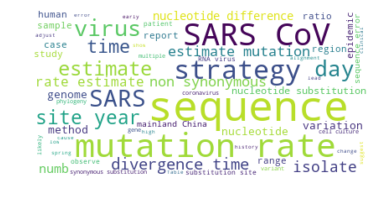

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=50, max_words=60, background_color="white").generate(" ".join(doc))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
doc_nlp = nlp(" ".join(doc))
query_nlp = nlp(" ".join(query))
query_nlp.similarity(doc_nlp)

0.5816764490959738

In [ ]:
nlp.max_length = 10000000
def find_similar_passage(query, df, k):
    """
    Args:
        query (nlp): The query to search through the corpus
        df (dataframe): The datafram containing all the documents and passages
        k (int): 
    output:
        array: An array containing the top k passages similar to query
    """
    
    # all docs with text
    docs = df[df.text != ""]
    max_sim = 0
    max_doc = None
    max_passage = None
    
    for doc_index in range(len(docs)):
        doc = docs.iloc[doc_index]
        doc_text = " ".join(doc.text)
        doc_nlp = nlp(" ".join(tokenizer(doc_text)))
        similarity = query.similarity(doc_nlp)
        if similarity > max_sim:
            max_sim = similarity
            max_doc = doc
        # go through all passages of doc
#         for passage_index in range(len(doc.text)):
#             passage = doc.text[passage_index]
#             passage_nlp = nlp(" ".join(tokenizer(passage)))
#             similarity = query.similarity(passage_nlp)
#             if similarity > max_sim:
#                 max_sim = similarity
#                 max_doc = doc
#                 max_passage = passage
    return max_sim, max_doc, max_passage

In [ ]:
max_sim, max_doc, max_passage = find_similar_passage(query_nlp, df, 5)
print(max_sim, max_doc, max_passage)
# doc = df[df.text != ""]
# for i in range:
#     print(doc)
    

In [20]:
nlp.max_length = 10000000
def build_tokenize_corpus(df):
    corpus = []
    docs = df[df.abstract.notna()]
    for i in range(len(docs)):
        doc = docs.iloc[i]
        try:
            text = tokenizer(doc.abstract)
        except:
            print(doc.abstract)
        corpus+= text
    return corpus

corpus = build_tokenize_corpus(df)

In [21]:
print(corpus[-1])
bm25 = 0

host


In [22]:
bm25 = BM25Plus(corpus)

In [23]:
print(corpus[1])
# docs = df[df.text != ""]
print(query)
doc_scores = bm25.get_scores(query)
doc_indexes = np.argsort(doc_scores)[::-1]
print(doc_scores[doc_indexes])
# docs.iloc[doc_indexes[:5]]
# print(bm25.get_top_n(query, corpus, n=1))

etiologic
['Range', 'incubation', 'period', 'disease', 'human', 'vary', 'age', 'health', 'status', 'long', 'individual', 'contagious', 'recovery']
[0. 0. 0. ... 0. 0. 0.]
